In [67]:
%run ML.libaryPackage-1.0.0.ipynb

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
import warnings
from sklearn.metrics import roc_curve
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from imblearn.under_sampling import *
from sklearn.decomposition import PCA
from imblearn.combine import SMOTETomek
from lightgbm import LGBMClassifier
from sklearn.preprocessing import PolynomialFeatures

warnings.filterwarnings('ignore')
%matplotlib inline

## data checking ##

In [82]:
# train data checking
train_data = pd.read_csv('train.csv', encoding='CP949')
train_data

,custid,gender,총구매액,구매건수,평균구매가격,평균할부개월수,구매브랜드종류,내점일수,수입상품_구매비율,주말방문비율,가을_구매건수,겨울_구매건수,봄_구매건수,여름_구매건수,아침_구매건수,저녁_구매건수,점심_구매건수,주구매코너
0,18,0,680100,15,45340,1.7,9,10,26.7,100.0,NaN,9.0,6.0,NaN,NaN,6.0,9.0,화장품
1,21,0,353450,9,39272,1.2,6,8,11.1,37.5,NaN,5.0,4.0,NaN,3.0,NaN,6.0,영캐주얼
2,23,0,5671400,36,157539,2.8,22,16,5.6,37.5,7.0,17.0,12.0,NaN,10.0,11.0,15.0,장신구
3,26,0,1964000,28,70143,1.4,15,14,39.3,28.6,5.0,8.0,15.0,NaN,NaN,18.0,10.0,화장품
4,35,0,885000,5,177000,6.0,5,2,0.0,100.0,NaN,NaN,5.0,NaN,NaN,5.0,NaN,피혁A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,49952,1,6666517,93,71683,1.8,27,39,10.8,43.6,13.0,33.0,14.0,33.0,8.0,41.0,44.0,일반식품
4996,49954,0,3112100,17,183065,3.6,10,13,29.4,38.5,4.0,6.0,6.0,1.0,3.0,NaN,14.0,디자이너부띠끄
4997,49957,1,5852482,37,158175,2.6,14,21,40.5,19.0,12.0,6.0,6.0,13.0,16.0,NaN,21.0,화장품
4998,49975,1,654498,13,50346,2.5,10,7,7.7,14.3,6.0,4.0,2.0,1.0,NaN,2.0,11.0,피혁A


In [20]:
# 예측할 new data 확인
test_data = pd.read_csv('test.csv', encoding='CP949')
test_data

,custid,총구매액,구매건수,평균구매가격,평균할부개월수,구매브랜드종류,내점일수,수입상품_구매비율,주말방문비율,가을_구매건수,겨울_구매건수,봄_구매건수,여름_구매건수,아침_구매건수,저녁_구매건수,점심_구매건수,주구매코너
0,100001,3439000,25,137560,2.2,19,16,12.0,31.2,5.0,4.0,7.0,9.0,13.0,1.0,11.0,장신구
1,100002,2073090,39,53156,1.3,18,29,0.0,20.7,13.0,8.0,10.0,8.0,4.0,10.0,25.0,유아동복
2,100003,1303800,22,59264,1.8,14,12,0.0,41.7,6.0,7.0,3.0,6.0,3.0,1.0,18.0,유아동복
3,100004,6696522,46,145577,1.7,31,22,37.0,50.0,5.0,15.0,9.0,17.0,NaN,4.0,42.0,수입명품
4,100005,1297640,26,49909,2.3,13,9,11.5,22.2,18.0,NaN,5.0,3.0,NaN,NaN,26.0,스포츠
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,104996,670690,5,134138,1.4,5,4,0.0,75.0,1.0,2.0,2.0,NaN,1.0,1.0,3.0,일반식품
4996,104997,628700,13,48362,1.8,10,7,7.7,42.9,NaN,5.0,1.0,7.0,NaN,3.0,10.0,조리욕실
4997,104998,960923,12,80077,1.8,7,7,0.0,42.9,4.0,1.0,6.0,1.0,NaN,NaN,12.0,일반식품
4998,104999,786600,14,56186,1.7,12,9,14.3,55.6,NaN,7.0,4.0,3.0,2.0,4.0,8.0,화장품


In [21]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   custid     5000 non-null   int64  
 1   gender     5000 non-null   int64  
 2   총구매액       5000 non-null   int64  
 3   구매건수       5000 non-null   int64  
 4   평균구매가격     5000 non-null   int64  
 5   평균할부개월수    5000 non-null   float64
 6   구매브랜드종류    5000 non-null   int64  
 7   내점일수       5000 non-null   int64  
 8   수입상품_구매비율  5000 non-null   float64
 9   주말방문비율     5000 non-null   float64
 10  가을_구매건수    4055 non-null   float64
 11  겨울_구매건수    4103 non-null   float64
 12  봄_구매건수     4311 non-null   float64
 13  여름_구매건수    3978 non-null   float64
 14  아침_구매건수    3558 non-null   float64
 15  저녁_구매건수    4033 non-null   float64
 16  점심_구매건수    4855 non-null   float64
 17  주구매코너      5000 non-null   object 
dtypes: float64(10), int64(7), object(1)
memory usage: 703.2+ KB
<class 'pandas.core.frame.Da

In [22]:
display(train_data.shape)
display(test_data.shape)

(5000, 18)

(5000, 17)

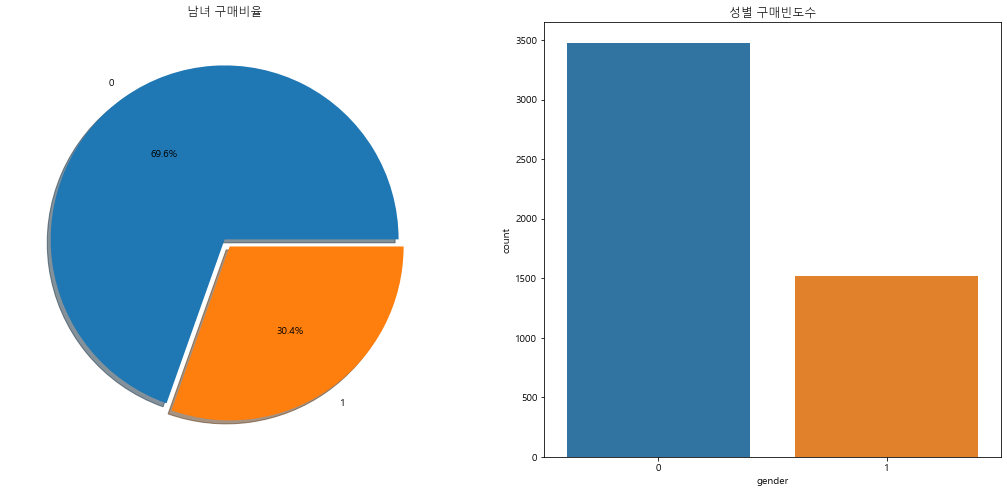

In [23]:
f, ax = plt.subplots(1,2,figsize=(18,8))

# 구매에 대한 남녀 빈도 체크
gender_freq = train_data.gender.value_counts()
gender_freq.plot.pie(explode=[0,0.05], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('남녀 구매비율', fontproperties=font_prop)
ax[0].set_ylabel('')

# 구매에 대한 남녀 빈도 체크 -> 히스토그램
sns.countplot('gender', data=train_data, ax=ax[1])
ax[1].set_title('성별 구매빈도수', fontproperties=font_prop)
plt.show()

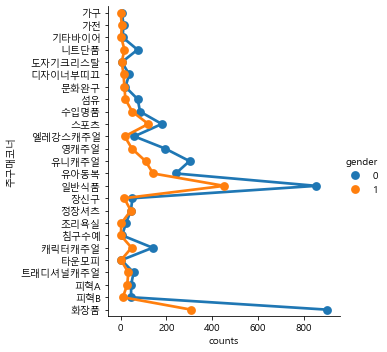

In [24]:
# 남녀별 주구매코너별 구매율
gender_catcnt = train_data.groupby(['gender', '주구매코너'])['custid'].agg('count').to_frame()
df_catecnt = gender_catcnt.reset_index()
df_catecnt.columns = ['gender', '주구매코너', 'counts']

sns.factorplot('counts', '주구매코너', hue='gender', data=df_catecnt)

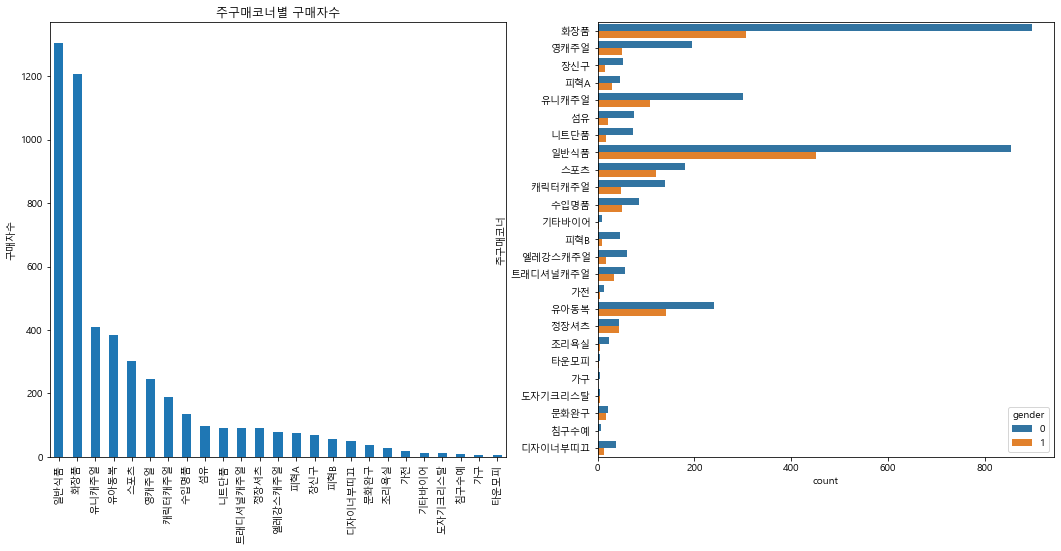

In [25]:
# 일반식품 -> 화장품 순으로 구매자수가 많음
# 여자는 화장품 -> 일반식풉 -> 유니캐주얼 순이고, 남자는 일반식품 -> 화장품 -> 유아동복 순으로 구매함.
f, ax = plt.subplots(1,2, figsize=(18,8))
train_data['주구매코너'].value_counts().plot.bar(ax=ax[0])
ax[0].set_title('주구매코너별 구매자수')
ax[0].set_ylabel('구매자수')
sns.countplot(y='주구매코너', hue='gender', data=train_data, ax=ax[1])
plt.show()

In [26]:
pd.crosstab(train_data['주구매코너'], train_data['gender'], margins=True).style.background_gradient(cmap='summer_r')

gender,0,1,All
주구매코너,,,
가구,6,1,7
가전,13,5,18
기타바이어,9,3,12
니트단품,74,17,91
도자기크리스탈,6,5,11
디자이너부띠끄,38,13,51
문화완구,21,17,38
섬유,75,21,96
수입명품,85,51,136


## Missing Values 처리 ##

In [27]:
# Missing Values 확인
trainData = train_data.copy() 
have_missing_value(trainData)

custid          0
gender          0
총구매액            0
구매건수            0
평균구매가격          0
평균할부개월수         0
구매브랜드종류         0
내점일수            0
수입상품_구매비율       0
주말방문비율          0
가을_구매건수       945
겨울_구매건수       897
봄_구매건수        689
여름_구매건수      1022
아침_구매건수      1442
저녁_구매건수       967
점심_구매건수       145
주구매코너           0
dtype: int64

In [28]:
# Feature 정의
# 수치형 Features
cont = ['총구매액','구매건수','평균구매가격','평균할부개월수','내점일수',
       '수입상품_구매비율','주말방문비율', '봄_구매건수', '여름_구매건수',
       '가을_구매건수','겨울_구매건수','아침_구매건수', '점심_구매건수',
       '저녁_구매건수', '구매브랜드종류']
# 범주형 Features
cate = ['주구매코너']
# 비분석 Features : drop
delCols = ['custid']
# target Feature
dfy = 'gender'

In [29]:
trainData

,custid,gender,총구매액,구매건수,평균구매가격,평균할부개월수,구매브랜드종류,내점일수,수입상품_구매비율,주말방문비율,가을_구매건수,겨울_구매건수,봄_구매건수,여름_구매건수,아침_구매건수,저녁_구매건수,점심_구매건수,주구매코너
0,18,0,680100,15,45340,1.7,9,10,26.7,100.0,NaN,9.0,6.0,NaN,NaN,6.0,9.0,화장품
1,21,0,353450,9,39272,1.2,6,8,11.1,37.5,NaN,5.0,4.0,NaN,3.0,NaN,6.0,영캐주얼
2,23,0,5671400,36,157539,2.8,22,16,5.6,37.5,7.0,17.0,12.0,NaN,10.0,11.0,15.0,장신구
3,26,0,1964000,28,70143,1.4,15,14,39.3,28.6,5.0,8.0,15.0,NaN,NaN,18.0,10.0,화장품
4,35,0,885000,5,177000,6.0,5,2,0.0,100.0,NaN,NaN,5.0,NaN,NaN,5.0,NaN,피혁A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,49952,1,6666517,93,71683,1.8,27,39,10.8,43.6,13.0,33.0,14.0,33.0,8.0,41.0,44.0,일반식품
4996,49954,0,3112100,17,183065,3.6,10,13,29.4,38.5,4.0,6.0,6.0,1.0,3.0,NaN,14.0,디자이너부띠끄
4997,49957,1,5852482,37,158175,2.6,14,21,40.5,19.0,12.0,6.0,6.0,13.0,16.0,NaN,21.0,화장품
4998,49975,1,654498,13,50346,2.5,10,7,7.7,14.3,6.0,4.0,2.0,1.0,NaN,2.0,11.0,피혁A


In [30]:
# 대체값 0으로 수치형 Feature 결측치 처리 : 
Impute_missing_value_numeric(trainData, cont, 0)
have_missing_value(trainData)

custid       0
gender       0
총구매액         0
구매건수         0
평균구매가격       0
평균할부개월수      0
구매브랜드종류      0
내점일수         0
수입상품_구매비율    0
주말방문비율       0
가을_구매건수      0
겨울_구매건수      0
봄_구매건수       0
여름_구매건수      0
아침_구매건수      0
저녁_구매건수      0
점심_구매건수      0
주구매코너        0
dtype: int64

In [31]:
# 범주형 결측치 One-hot encoding 처리
dataP =Impute_missing_value_categorical(trainData, cate)

['주구매코너'].astype('category').cat.categories


In [32]:
# 학습용 데이터 확인
dataP.tail(3)

,custid,gender,총구매액,구매건수,평균구매가격,평균할부개월수,구매브랜드종류,내점일수,수입상품_구매비율,주말방문비율,가을_구매건수,겨울_구매건수,봄_구매건수,여름_구매건수,아침_구매건수,저녁_구매건수,점심_구매건수,주구매코너
4997,49957,1,5852482,37,158175,2.6,14,21,40.5,19.0,12.0,6.0,6.0,13.0,16.0,0.0,21.0,24
4998,49975,1,654498,13,50346,2.5,10,7,7.7,14.3,6.0,4.0,2.0,1.0,0.0,2.0,11.0,22
4999,49993,1,2554723,32,79835,1.7,9,26,21.9,34.6,6.0,5.0,10.0,11.0,8.0,5.0,19.0,14


 ## Modeling ##

In [33]:
# 데이터 분할(Split Data)
X_train, X_test, y_train, y_test = data_split_train_test(trainData, delCols, dfy, 0.25)
print(X_train.shape, X_test.shape)

(3750, 16) (1250, 16)


In [34]:
# decision tree 로 모델링
decisionTree_modeling(X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.71      0.91      0.80       883
           1       0.31      0.10      0.15       367

    accuracy                           0.67      1250
   macro avg       0.51      0.50      0.47      1250
weighted avg       0.59      0.67      0.61      1250



In [35]:
# svm 으로 모델링
svm_modeling(X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.71      0.99      0.83       883
           1       0.54      0.02      0.04       367

    accuracy                           0.71      1250
   macro avg       0.62      0.51      0.43      1250
weighted avg       0.66      0.71      0.60      1250



In [36]:
# neural network 모델 적용
neural_network_modeling(X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.76      0.07      0.12       883
           1       0.30      0.95      0.45       367

    accuracy                           0.33      1250
   macro avg       0.53      0.51      0.29      1250
weighted avg       0.63      0.33      0.22      1250



- dataP.gender.value_counts()  # <font color='red'>비대칭 데이터</font> 확인
 - 0    3479
 - 1    1521
 - Name: gender, dtype: int64
 
#### DecisionTree, SVM, neural network 알고리즘으로 모델링한 결과,
- 남성의 데이터가 적어서 재현율이 현격히 낮은 현상이 나타남.

In [37]:
trainData.gender.value_counts()

0    3479
1    1521
Name: gender, dtype: int64

- 비대칭 데이터는 데이터 비율을 맞추면 정밀도(precision)가 향상된다.
 - 오버샘플링(Over-Sampling)  : 소수 클래스 데이터를 추가함.
 - 언더샘플링(Under-Sampling) : 다수 클래스 데이터에서 일부만 사용함.
 - 복합샘플링(Combining Over-and Under-Sampling)
 
- pip install -U imbalanced-learn


### <font color = "#CC3D3D">Tomek links<font>: a under-sampling class method 
- Under-Sampling 기법은 precision/recall/f1-score 개선이 미미함...

In [68]:
under_Sampling_DecisionTree(X_train, y_train)

              precision    recall  f1-score   support

           0       0.72      0.49      0.58       836
           1       0.61      0.81      0.70       829

    accuracy                           0.65      1665
   macro avg       0.67      0.65      0.64      1665
weighted avg       0.67      0.65      0.64      1665



### <font color = "#CC3D3D">SMOTE + Tomek</font>
- precision/recall/f1-score 모두 <font color="blue">개선</font>됨 => 따라서, Hybrid 샘플링을 하기로 결정함.

In [69]:
combining_Sampling_DecisionTree(X_train, y_train)

              precision    recall  f1-score   support

           0       0.73      0.49      0.58       836
           1       0.61      0.82      0.70       829

    accuracy                           0.65      1665
   macro avg       0.67      0.65      0.64      1665
weighted avg       0.67      0.65      0.64      1665



## Features engineering ##

In [70]:
# 학습용 데이터에 '코너별구매건' 컬럼 추가
dt0 = dataP.groupby(['주구매코너'])['구매건수'].agg(sum)   
# to_frame() : Series를 DataFrame으로 간단하게 변환
# set_index : 기존의 행 인덱스를 제거하고 데이터 열 중 하나를 인덱스로 설정
# reset_index : 기존의 행 인덱스를 제거하고 인덱스를 마지막 데이터 열로 추가
df0 = dt0.to_frame().reset_index() 
df0.columns = ['주구매코너', '코너별구매건']
#df0.head(3)
# merge 명령은 두 데이터 프레임의 공통 열 혹은 인덱스를 기준으로 두 개의 테이블을 합친다. 
# 이 때 기준이 되는 열, 행의 데이터를 키(key)라고 한다.
dataP_ = pd.merge(dataP, df0, on='주구매코너')
# dataP_.head()
print(dataP_[(dataP_['주구매코너']==1)].groupby(['gender'])['총구매액'].agg(sum))
print(dataP_[(dataP_['주구매코너']==1)].groupby(['gender'])['구매건수'].agg(sum))
dataP_.head(2)

gender
0    31111117
1    29039091
Name: 총구매액, dtype: int64
gender
0    214
1    101
Name: 구매건수, dtype: int64


,custid,gender,총구매액,구매건수,평균구매가격,평균할부개월수,구매브랜드종류,내점일수,수입상품_구매비율,주말방문비율,가을_구매건수,겨울_구매건수,봄_구매건수,여름_구매건수,아침_구매건수,저녁_구매건수,점심_구매건수,주구매코너,코너별구매건
0,18,0,680100,15,45340,1.7,9,10,26.7,100.0,0.0,9.0,6.0,0.0,0.0,6.0,9.0,24,25740
1,26,0,1964000,28,70143,1.4,15,14,39.3,28.6,5.0,8.0,15.0,0.0,0.0,18.0,10.0,24,25740


In [71]:
# 건수 Feature들을 최소단위 정보인 구매건당 구매액로 변경
def createFeatures(df_p):
    df_p['아침구매액'] = np.round(df_p['총구매액']*(df_p['아침_구매건수'] /df_p['구매건수'] ), 3)
    df_p['점심구매액'] = np.round(df_p['총구매액']*(df_p['점심_구매건수'] /df_p['구매건수'] ), 3)
    df_p['저녁구매액'] = np.round(df_p['총구매액']*(df_p['저녁_구매건수'] /df_p['구매건수'] ), 3)  
    df_p['봄구매액']   = np.round(df_p['총구매액']*(df_p['봄_구매건수'] /df_p['구매건수'] ), 3) 
    df_p['여름구매액'] = np.round(df_p['총구매액']*(df_p['여름_구매건수'] /df_p['구매건수'] ), 3) 
    df_p['가을구매액'] = np.round(df_p['총구매액']*(df_p['가을_구매건수'] /df_p['구매건수'] ), 3)  
    df_p['겨울구매액'] = np.round(df_p['총구매액']*(df_p['겨울_구매건수'] /df_p['구매건수'] ), 3)  
    df_p['내점구매율'] = np.round(df_p['구매건수'] /df_p['내점일수'], 3)

def dropFeatures(df_p):
    drop_cols = ['아침_구매건수', '점심_구매건수', '저녁_구매건수', '총구매액', '구매건수',
         '봄_구매건수', '여름_구매건수', '가을_구매건수', '겨울_구매건수', '내점일수'] 
    
    return df_p.drop(drop_cols, axis=1)

createFeatures(dataP_)
dataPP = dropFeatures(dataP_) 
dataPP[(dataPP['주구매코너']==2)].head(3)

,custid,gender,평균구매가격,평균할부개월수,구매브랜드종류,수입상품_구매비율,주말방문비율,주구매코너,코너별구매건,아침구매액,점심구매액,저녁구매액,봄구매액,여름구매액,가을구매액,겨울구매액,내점구매율
4123,363,0,90960,3.0,4,20.0,25.0,2,149,0.000,90960.000,363840.000,454800.000,0.000,0.000,0.000,1.250
4124,4822,0,248049,2.3,10,10.5,33.3,2,149,992196.632,3224639.053,496098.316,744147.474,992196.632,1736344.105,1240245.789,1.583
4125,11617,1,124767,3.8,8,25.0,62.5,2,149,124766.667,499066.667,873366.667,249533.333,499066.667,748600.000,0.000,1.500


In [84]:
dataPP

,custid,gender,평균구매가격,평균할부개월수,구매브랜드종류,수입상품_구매비율,주말방문비율,주구매코너,코너별구매건,아침구매액,점심구매액,저녁구매액,봄구매액,여름구매액,가을구매액,겨울구매액,내점구매율
0,18,0,45340,1.7,9,26.7,100.0,24,25740,0.000000e+00,4.080600e+05,272040.000,272040.000,0.000000e+00,0.000000e+00,4.080600e+05,1.500
1,26,0,70143,1.4,15,39.3,28.6,24,25740,0.000000e+00,7.014286e+05,1262571.429,1052142.857,0.000000e+00,3.507143e+05,5.611429e+05,2.000
2,82,0,150440,2.6,5,60.0,100.0,24,25740,0.000000e+00,7.522000e+05,0.000,752200.000,0.000000e+00,0.000000e+00,0.000000e+00,1.667
3,92,0,88108,1.9,7,23.1,22.2,24,25740,8.810769e+04,3.524308e+05,704861.538,176215.385,8.810769e+05,8.810769e+04,0.000000e+00,1.444
4,100,0,27635,1.0,10,25.0,33.3,24,25740,0.000000e+00,3.592550e+05,82905.000,303985.000,0.000000e+00,0.000000e+00,1.381750e+05,2.667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,49369,1,79913,2.6,10,26.1,8.3,5,2219,7.991304e+04,1.598261e+06,159826.087,0.000,1.518348e+06,3.196522e+05,0.000000e+00,1.917
4996,49582,0,258241,2.6,17,18.9,15.0,5,2219,1.291203e+06,7.488976e+06,774721.622,4648329.730,1.291203e+06,2.065924e+06,1.549443e+06,1.850
4997,49618,1,101851,2.7,14,6.1,19.0,5,2219,1.120357e+06,1.935163e+06,305552.000,1018506.667,8.148053e+05,7.129547e+05,8.148053e+05,1.571
4998,49732,0,314259,5.1,23,18.8,24.4,5,2219,1.477015e+07,3.928233e+07,5970913.539,8484982.398,2.388365e+07,1.445590e+07,1.319886e+07,2.449


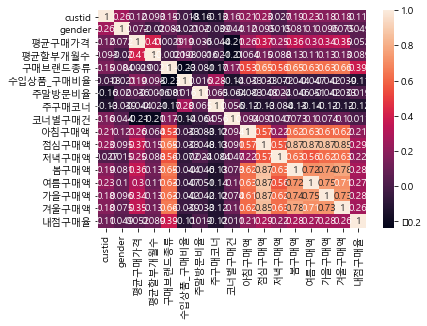

In [72]:
sns.heatmap(dataPP.corr(), annot=True)

In [73]:
pd.DataFrame(abs(dataPT.corr()['gender']).sort_values(ascending = False))

,gender
gender,1.000000
custid,0.262472
아침구매액,0.120622
여름구매액,0.102140
가을구매액,0.095573
점심구매액,0.094617
구매브랜드종류,0.083988
봄구매액,0.081081
겨울구매액,0.074530
평균구매가격,0.072181


In [74]:
# 학습용 데이터 확정

dataPT = dataPP.copy()
dataPD = dataPT.drop(['주말방문비율', '저녁구매액', '평균할부개월수','수입상품_구매비율','주구매코너'], axis=1)

dfX = dataPD.drop('gender', axis=1)
dfy = dataPD['gender']

dfX.tail(2)

,custid,평균구매가격,구매브랜드종류,코너별구매건,아침구매액,점심구매액,봄구매액,여름구매액,가을구매액,겨울구매액,내점구매율
4998,49732,314259,23,2219,1.477015e+07,3.928233e+07,8484982.398,2.388365e+07,1.445590e+07,1.319886e+07,2.449
4999,49954,183065,10,2219,5.491941e+05,2.562906e+06,1098388.235,1.830647e+05,7.322588e+05,1.098388e+06,1.308


In [75]:
dfX.shape

(5000, 11)

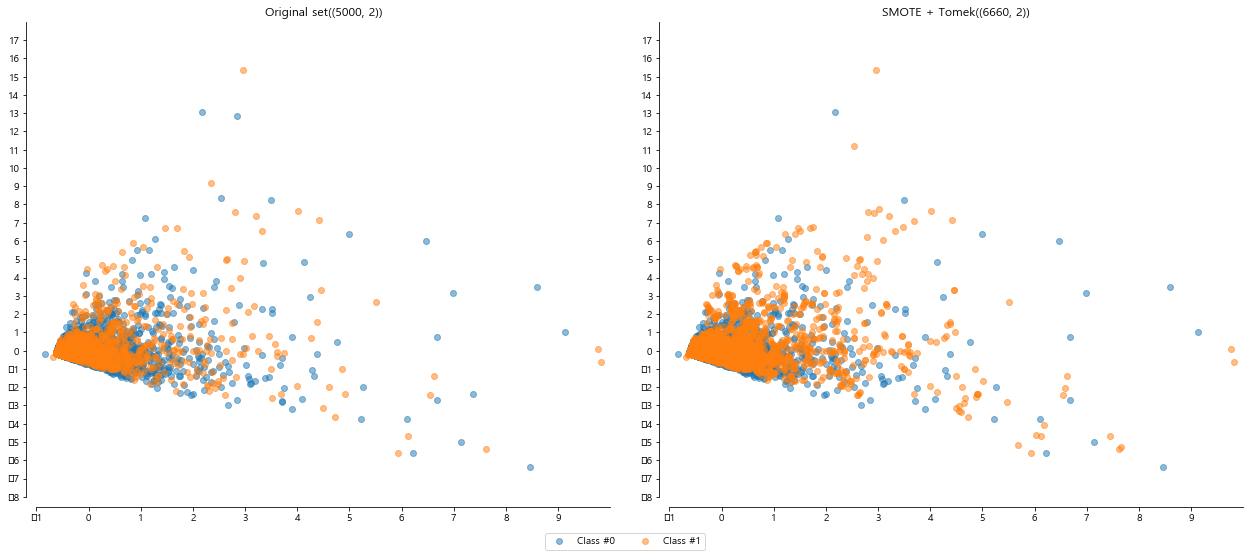

(5000, 11) (6660, 11) (4995, 11) (1665, 11)


In [76]:
from imblearn.combine import *

# PCA로 feature 2개만 선택하여 Scatter로 시각화해 봄..
pca = PCA(n_components=2)
X_org = pca.fit_transform(dfX)
y_org = np.array(dfy)
X_resampled, y_resampled = SMOTETomek(random_state=0).fit_sample(dfX, dfy)
X_pca = pca.transform(X_resampled)

scaler = StandardScaler()
X_org_scaled = scaler.fit_transform(X_org)
X_pca_scaled = scaler.transform(X_pca)

title1 = 'Original set('+ str(X_org_scaled.shape) +')'
title2 = 'SMOTE + Tomek('+ str(X_pca_scaled.shape) +')'
xlim = [-1, 10]
ylim = [-8, 18]
xticks = range(-1, 10)
yticks = range(-8, 18)

# Scatter 그래프 그리기
drawSMOTETomek(X_org_scaled, y_org, X_pca_scaled, y_resampled, title1, title2, xlim, ylim, xticks, yticks)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=0)
print(dfX.shape, X_resampled.shape, X_train.shape, X_test.shape)

- <font color="red">SMOTETomek</font> 비대칭 데이터 OverSampling 처리
 - Scatter 그래프로 시각화하여 비교하기 위해 PCA와 StandardScaler를 사용함.
 - 실제 학습용으로는 SMOTETomek로 샘플링한 X_resampled, y_resampled를 사용함.

In [77]:
# scoring="roc_auc|f1" => 0.496
temp_param1 = bestModel('SVC', 5, 'GRID', X_train, y_train, 'minmax', True, False, 'f1', -1, 10, 5)
best_param1 = {key.split("__")[1]:value for key, value in temp_param1.items() if key != 'polynomialfeatures__degree'}
svm1 = SVC(**best_param1)
score_svm1 = svm1.fit(X_train, y_train).score(X_test, y_test)
print("score_svm1 ::: {}".format(score_svm1))
print("-----------------------------------")
y_svm1 = svm1.predict(X_test)
print(classification_report(y_test, y_svm1))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.6min finished


score_svm1 ::: 0.4978978978978979
-----------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       836
           1       0.50      1.00      0.66       829

    accuracy                           0.50      1665
   macro avg       0.25      0.50      0.33      1665
weighted avg       0.25      0.50      0.33      1665



- RandomizedSearchCV LGBM
 - StratifiedShuffleSplit + RandomizedSearchCV
 - precision/recall/f1-score이 <font color="blue">균형(최고=0.755)</font> 상태로 개선됨.
 - <font color="green"><b>def</b></font> bestGBDTNextModel(model, isKfold, nfold, searchCV, Xtrain, ytrain, Xtest, ytest, nIter, scoring, errScore, verbose, nJobs)
 - 카테고리 Feature이 '주구매코너'를 삭제하여 LGBM.categorical_feature 속성은 무시함.

In [78]:
# scoring="roc_auc|f1" => 0.755
# categories_indices = [X_train.columns.get_loc(col) for col in ['주구매코너']]
best_param1 = bestGBDTNextModel('LGBM', False, 5, 'RANDOM', X_train, y_train, X_test, y_test, 15, 'roc_auc', 0, 3, -1)
lgbm1 = LGBMClassifier(**best_param1)
score_lgbm1 = lgbm1.fit(X_train, y_train).score(X_test, y_test)
print("score_lgbm1 ::: {}".format(score_lgbm1))
print("-----------------------------------")
y_lgbm1 = lgbm1.predict(X_test)
print(classification_report(y_test, y_lgbm1))

# 최고=0.755 Score LGBM best_estimator
#  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
#         importance_type='split', lambda_l1=0.01, lambda_l2=0,
#         learning_rate=0.01, max_depth=50, metric='auc',
#         min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
#         min_split_gain=0.0, n_estimators=300, n_jobs=-1,
#         num_boost_round=4000, num_leaves=150, objective='binary',
#         random_state=0, reg_alpha=0.1, reg_lambda=0.0, silent=True,
#         subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.6s finished


LightGBMError: Do not support non-ASCII characters in feature name.

## 전개(Deployment) ##

In [ ]:
# 1. 예측용 데이터를 로드한다.
news = pd.read_csv('./data/test.csv', encoding='CP949')
newsP = news.copy()
newsP.head(2)

In [ ]:
have_missing_value(newsP)

In [ ]:
# 2. 예측용 데이터 결측치 처리 및 비분석 컬럼 삭제 
newsP.fillna(value=0, inplace=True)

for col in newsP[cate].dtypes.index:
    print("newsP['"+ col +"'].astype('category').cat.categories")
    newsP[col].astype('category').cat.categories

newsP[cate] = newsP[cate].apply(lambda x: x.astype('category').cat.codes)
newsP.tail(3)

In [ ]:
# 3. 예측용 데이터에 '코너별구매건' 컬럼 추가
nd0 = newsP.groupby(['주구매코너'])['구매건수'].agg(sum)   
nd0 = nd0.to_frame().reset_index()
nd0.columns = ['주구매코너', '코너별구매건']
# nd0.head(3)
newsP_ = pd.merge(newsP, nd0, on='주구매코너')
# newsP_.head(2)

# 4. 예측용 데이터의 건수 Feature들을 최소단위 정보인 구매건당 구매액로 변경한다.
createFeatures(newsP_)
newsPP = dropFeatures(newsP_) # 파생 Feature -> 유도 Feature들 삭제
# newsPP[(newsPP['주구매코너']==2)].head(3)

# 5. 머신러닝 예측용 데이터 변환 완료
X_pred = newsPP.drop(['주말방문비율', '저녁구매액', '평균할부개월수','수입상품_구매비율','주구매코너'], axis=1)
X_pred.tail(2)

### Best Model training ###

In [83]:
best_model1 = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
         importance_type='split', lambda_l1=0.01, lambda_l2=0,
         learning_rate=0.01, max_depth=50, metric='auc',
         min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
         min_split_gain=0.0, n_estimators=300, n_jobs=-1,
         num_boost_round=4000, num_leaves=150, objective='binary',
         random_state=0, reg_alpha=0.1, reg_lambda=0.0, silent=True,
         subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

score_best1 = best_model1.fit(X_train, y_train).score(X_test, y_test)
y_best1 = best_model1.predict(X_test)

print("best_model1 -----------------------------{}".format(score_best1))
print(classification_report(y_test, y_best1))

LightGBMError: Do not support non-ASCII characters in feature name.

In [ ]:
best_model2 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.07, max_delta_step=0,
        max_depth=7, min_child_weight=1, missing=None, n_estimators=700,
        n_jobs=1, nthread=3, objective='binary:logistic', random_state=0,
        reg_alpha=0.01, reg_lambda=0.1, scale_pos_weight=1, seed=None,
        silent=True, subsample=1)

score_best2 = best_model2.fit(X_train, y_train).score(X_test, y_test)
y_best2 = best_model2.predict(X_test)

print("best_model2 -----------------------------{}".format(score_best2))
print(classification_report(y_test, y_best2))

#### SMOTETomek로 재샘플링한 데이터가 narray 형식이므로 예측용 데이터도 narray로 변환하여 예측한다.

In [ ]:
new_D = X_pred.copy()
new_T = dataPT.drop(['주말방문비율', '저녁구매액', '평균할부개월수','수입상품_구매비율','주구매코너'], axis=1)
new_T = new_T.drop('gender', axis=1)
new_T.tail(2)

In [ ]:
display(dfX.shape, new_T.shape)

In [ ]:
new_D['pred']       = best_model1.predict(new_T)
new_D['pred_prob']  = best_model1.predict_proba(new_T)[:,1]

In [ ]:
news.sort_values(by=['custid']).tail(3)

In [ ]:
new_D.sort_values(by=['custid']).tail(3)

In [ ]:
dfN = new_D[['custid', 'pred', 'pred_prob']]
#dfN
targets = pd.merge(news, dfN, on='custid')
targets.tail(5)

In [ ]:
f, ax = plt.subplots(1,2,figsize=(18,8))

# 구매에 대한 남녀 빈도 체크
gender_freq = targets.pred.value_counts()
gender_freq.plot.pie(explode=[0,0.05], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('남녀 구매비율', fontproperties=font_prop)
ax[0].set_ylabel('')

# 구매에 대한 남녀 빈도 체크 -> 히스토그램
sns.countplot('pred', data=targets, ax=ax[1])
ax[1].set_title('성별 구매빈도수', fontproperties=font_prop)
plt.show()

In [ ]:
# 예측한 Data를 파일로 저장하여 제출한다.
targets.sort_values(by="custid", ascending=False).to_csv("ML_exam-sub.csv", index=False)
pd.read_csv("ML_exam-sub.csv").count()

In [ ]:
result_data = pd.read_csv('ML_exam-sub.csv')
result_data

In [ ]:
gender_freq = result_data.pred.value_counts()
gender_freq